**DATA VISUALIZATION**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

**FUZZY c-MEANS & ANOMALOUS PATTERN**

In [ ]:
 pip install -U scikit-fuzzy

In [ ]:
# We Reduce the number of observations to 1000. We also recompute all the relevant quantitites which we will use later for PC visualization
df=df[:1000]

labels=np.array(df.loc[:,['ocean_proximity','median_house_value']])
columns_dont_want = ['latitude','longitude','ocean_proximity','median_house_value']  #'median_house_value', longitude
select = [x for x in df.columns if x not in columns_dont_want]
data=np.array(df.loc[:, select])
data_mean = data.mean(axis=0)
data_std1 = data.std(axis=0)
data_std2=data.max(axis=0)-data.min(axis=0)
centered_data= (data - data_mean[None,:]) / data_std1[None,:]
centered_data2= (data - data_mean[None,:]) / data_std2[None,:]
U, s, VT = np.linalg.svd(centered_data, full_matrices =False)
Phi = np.matmul(centered_data,VT.transpose())
column_values=['1st_PC','2nd_PC','3rd_PC','ocean_proximity','median_house_value'] # ocean_proximity-> <1H OCEAN:0, INLAND:1, ISLAND:2 ,NEAR BAY:3, NEAR OCEAN:4
reduced_labels=np.array([1 if lab==1 else 0 for lab in labels[:,0]])
ddflabels=np.hstack((reduced_labels[:,None],labels[:,1][:,None]))

ddf = pd.DataFrame(data = np.hstack((Phi[:,:3],ddflabels)), 
                  columns = column_values)

In [ ]:
#XIE BENI VALIDATION INDEX

def XB(V,U,D,m):

  N=U.shape[1]
  diff_v=[]
  for i in range(V.shape[0]-1):
    for j in np.arange(i+1,V.shape[0]):
      diff_v.append(np.dot(V[i,:]-V[j,:],(V[i,:]-V[j,:]).transpose()))
  mindiff=min(diff_v)

  numerator=0
  for i in range(U.shape[0]):
    for j in range(U.shape[1]):
      numerator+=(D[i,j]**2)*(U[i,j]**m)

  return numerator/(mindiff*N)

In [ ]:
#PCAES VALIDATION INDEX

def PCAES(X,V,U,D,m):
  N=U.shape[1]
  v_mean=np.mean(X,axis=1)
  Vdiff=V-v_mean[None,:]
  beta=0
  uc_sqr=[]
  for k in range(Vdiff.shape[0]):
    beta+=np.dot(Vdiff[k,:],Vdiff[k,:].transpose())
    uc_sqr.append(np.sum(U[k,:]**2))

  u_m=min(uc_sqr)
  beta=beta/Vdiff.shape[0]
  
  res=0
  for k in range(U.shape[0]):
    diff_l=[]
    for i in range(U.shape[0]):
      if i!=k:
        diff_l.append(np.dot(V[k,:]-V[i,:],(V[k,:]-V[i,:]).transpose()))

    mindiff=min(diff_l)

    res+=np.sum((U[k,:]**2)/u_m)-np.exp(-mindiff/beta)
  
  return res

v_scores=  [1.2245704563062175e-32, 1.1302266380582484e-31, 3.5825506848843234e-31, 5.223274478632114e-31, 6.879803770893127e-32, 0.011848677395124555, 1.7344779631317104e-31, 5.923538149437408e-31]
u_scores=  [5.739036511561991e-33, 1.275407346141356e-32, 1.0119075420825522e-32, 2.0839270642688297e-32, 4.4198637113515434e-33, 0.0034905341320931272, 2.3460012503045845e-32, 1.030226116334295e-31]


Text(0.5, 0, 'number of prototypes')

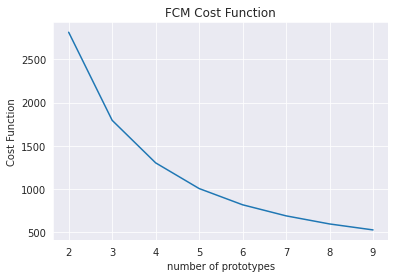

In [ ]:
# FUZZY C-MEANS ALGORITHM 

import skfuzzy as fuzz
# cntr,u,u0,d,jm,p,fcp fuzzy cmeans array output components in order
cmin=2
cmax=9
seeds=[1,22,43]
jm=[]
crange=np.arange(cmin,cmax+1)
v_scores=[]
u_scores=[]
XB_ind=[]
PCAES_ind=[]

def my_norm(v_list):  #Measures how close the the solutions obtained for different seeds are. It can be used both on he final prototypes matrix V and on the final membership matrix U
  v_mean=np.zeros(v_list[0].shape)

  for mat in np.arange(1,len(v_list)): # here we reorder the rows of the matrices in order to be referring to the "same" prototypes
    for i in range(v_mean.shape[0]):
      index=np.argmin(np.mean(abs(v_list[mat]-v_list[0][i,:][None,:]),axis=1))
      if index!=i:
         v_list[mat][[i,index],:]= v_list[mat][[index,i],:]
      
  for k in range(len(v_list)):
    v_mean+=v_list[k]
  v_mean=v_mean/len(v_list)
  res=0
  for k in range(len(v_list)):
    res+=np.sum((v_list[k]-v_mean)**2)/np.product(v_mean.shape)

  return res

for k in crange:
  jm_list=[]
  v_list=[]
  u_list=[]
  XB_list=[]
  PCAES_list=[]
  for se in seeds:
    result=fuzz.cmeans(data=centered_data.transpose(),c=k, m=2, error=10^(-2), maxiter=1000, init=None, seed=se)
    jm_list.append(result[4][-1])
    v_list.append(result[0])
    u_list.append(result[1])
    XB_list.append(XB(result[0],result[1],result[3],2))
    PCAES_list.append(PCAES(centered_data.transpose(),result[0],result[1],result[3],2))

  v_scores.append(my_norm(v_list))   # list containing how much the final protypes matrix oscillate for different values of the seed
  u_scores.append(my_norm(u_list))   # list containing how much the final membership matrix oscillate for different values of the seed
  jm.append(min(jm_list))
  XB_ind.append(min(XB_list))
  PCAES_ind.append(max(PCAES_list))

jm=np.array(jm)
#scores=np.array(scores)
XB_ind=np.array(XB_ind)
print('v_scores= ',v_scores)
print('u_scores= ',u_scores)
plt.plot(crange,jm)
plt.title("FCM Cost Function")
plt.ylabel("Cost Function")
plt.xlabel("number of prototypes")


Text(0.5, 0, 'number of cluster')

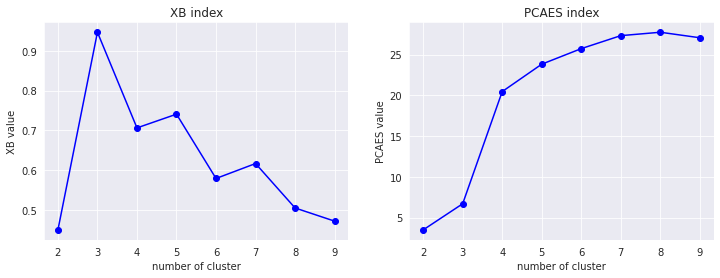

In [ ]:
# VALIDATION INDEX PLOT

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,4))

x=np.arange(2,10)
axes[0].plot(x,XB_ind[:8],'-bo')
axes[0].set_title("XB index")
axes[0].set_ylabel("XB value")
axes[0].set_xlabel("number of cluster")
axes[1].plot(x,PCAES_ind[:8],'-bo')
axes[1].set_title("PCAES index")
axes[1].set_ylabel("PCAES value")
axes[1].set_xlabel("number of cluster")


 **Anomalous pattern**

In [ ]:
def center_(x, cluster):
    """ finds the centroid of a cluster
    X - the original data matrix
     cluster - the set with indices of the objects belonging to the cluster
    """
    #number of columns
    mm = x.shape[1]
    centroidC = []
    
    for j in range(mm):
        zz = x[:, j]
        zc = []
        for i in cluster:
            zc.append(zz[i])
        centroidC.append(np.mean(zc))
    return centroidC


def distNorm(x ,remains, ranges, p):
    """ Finds the normalized distances of data points in 'remains' to reference point 'p' 
     X - the original data matrix;
     remains- the set of X-row indices under consideration
     ranges- the vector with ranges of data features 
     p - the data point the distances relate to
     distan- the output column of distances from a to remains """

    #number of columns
    mm = x.shape[1]
    rr = len(remains)
    z = x[remains, :]
    az = np.tile(np.array(p), (rr, 1))
    rz = np.tile(np.array(ranges), (rr, 1))
    dz = (z - az) / rz
    dz = np.array(dz)
    ddz = dz * dz
    if mm > 1:
        di = sum(ddz.T)
    else:
        di = ddz.T
    distan = di
    return distan


def separCluster(x0, remains, ranges, a, b):
    """  Builds a cluster by splitting the points around refernce point 'a' from those around reference point b 
    x0 - data matrix
    remains- the set of X-row indices under consideration
    ranges- the vector with ranges of data features 
    a, b - the reference points
    cluster - set with row indices of the objects belonging to the cluster  
    """
    
    dista = distNorm(x0, remains, ranges, a)
    distb = distNorm(x0, remains, ranges, b)
    clus = np.where(dista < distb)[0]
    cluster = []
    for i in clus:
        cluster.append(remains[i])
    return cluster

def anomalousPattern(x, remains, ranges, centroid, me):
    """ Builds one anomalous cluster based on the algorithm 'Separate/Conquer' (Mirkin, 1999, Machine Learning Journal) 
        X - data matrix,
        remains - set of its row indices (objects) under consideration,
        ranges - normalizing values: the vector with ranges of data features  
        centroid - initial center of the anomalous cluster being build
        me - vector to shift the 0 (origin) to,
        output: cluster - set of row indices in the anomalous cluster, 
        centroid -center of the cluster    """
        
    key = 1
    while key == 1:
        cluster = separCluster(x, remains, ranges, centroid, me)
        if len(cluster) != 0:
            newcenter = center_(x, cluster)
        if  len([i for i, j in zip(centroid, newcenter) if i == j]) != len(centroid):
            centroid = newcenter
        else:
            key = 0
    return (cluster, centroid)

def dist(x, remains, ranges, p):
    """ Calculates the normalized distances of data points in 'remains' to reference point 'p'   
        X - data matrix,
        remains - set of its row indices (objects) under consideration,
        ranges - normalizing values: the vector with ranges of data features  
    
       distan - the calculated normalized distances
    """

    #number of columns
    mm = x.shape[1]
    rr = len(remains)
    distan = np.zeros((rr,1))    
    for j in range(mm):
        z = x[:, j]
        z = z.reshape((-1,1))
        zz = z[remains]
        y = zz - p[j]
        y = y / ranges[j]
        y = np.array(y)
        yy = y * y
        distan = distan + yy
    return distan

In [ ]:
normalization = 1 #if 1 it uses z-score normalization if 0 normalize by range
# threshold value (this is an example)
threshold = 12 #here we leave a very permissive threshold we will then choose a more strict one based on more considerations


x = data
#y = data.target

#number of data points
nn = x.shape[0]
#number of features
mm = x.shape[1]

# grand means
me = []
# maximum value
mmax = []
# minimum value
mmin = []
#std value
std = []
# ranges
ranges = []
# data structure to keep everything together
ancl = []


for j in range(mm): # for each feature
    z = x[:, j]
    me.append(np.mean(z))
    mmax.append(np.max(z))
    mmin.append(np.min(z))
    std.append(np.std(z))

    if normalization:
        ranges.append(std[j])
    else:
        ranges.append(mmax[j] - mmin[j])
    if ranges[j] == 0:
        print("Variable num {} is contant!".format(j))
        ranges[j] = 1
    
sy = np.divide((x - me), ranges)
sY = np.array(sy)
d = np.sum(sY * sY)   # total data scatter of normalized data

In [ ]:
remains = list(range(nn))  # current index set of residual data after some anomalous clusters are extracted
numberC = 0; # anomalous cluster counter
while(len(remains) != 0):
    distance = dist(x, remains, ranges, me) # finding normalised distance vector from remains data points to reference 'me'
    ind = np.argmax(distance)
    index = remains[ind]
    centroid = x[index, :] # initial anomalous center reference point
    numberC = numberC + 1
    
    (cluster, centroid) = anomalousPattern(x, remains, ranges, centroid, me) # finding AP cluster
    
    
    censtand = np.divide((np.asarray(centroid) - me), np.asarray(ranges)) # standardised centroid   
    dD = np.sum(np.divide(censtand * censtand.T * len(cluster) * 100, d))   # cluster contribution, per cent 

    remains = np.setdiff1d(remains, cluster) 
    # update the data structure that keeps everything together
    ancl.append(cluster)   # set of data points in the cluster
    ancl.append(censtand)  # standardised centroid
    ancl.append(dD) # proportion of the data scatter
    
ancl = np.asarray(ancl)
ancl = ancl.reshape((numberC, 3))
##aK = numberC
b = 3
ll = [] # list of clusters

for ik in range(numberC):
    ll.append(len(ancl[ik, 0]))
    
rl = [i for i in ll if i >= threshold] # list of clusters with at least threshold elements
cent = []
if(len(rl) == 0):
    print('Too great a threhsold!!!')
else:
    num_cents = 0
    for ik in range(numberC):
        cluster = ancl[ik,0]
        if(len(cluster) >= threshold):
            cent.append(ancl[ik, 1])
            num_cents += 1
                
cent = np.asarray(cent)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
z=[]
v=[]
for i in range(len(ancl)): 
   z.append(len(ancl[i][0]))
   v.append(ancl[i][2])
print(z)

[69, 376, 171, 122, 91, 85, 19, 23, 23, 12, 1, 2, 1, 1, 1, 1, 1, 1]


Text(0.5, 0, 'cluster number')

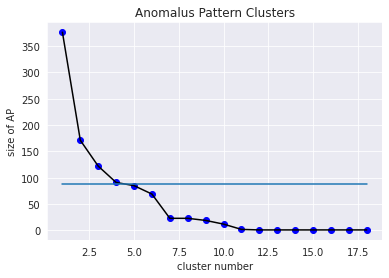

In [ ]:
cl=np.arange(1,len(z)+1)
plt.plot(cl,sorted(z,reverse=True),'bo')
plt.plot(cl,sorted(z,reverse=True),'k')
plt.plot(cl,88*np.ones(len(z)))

plt.title("Anomalus Pattern Clusters")
plt.ylabel('size of AP')
plt.xlabel('cluster number')



Text(0.5, 0, 'cluster number')

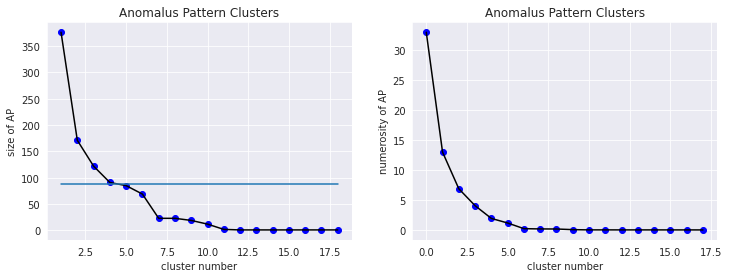

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
cl=np.arange(1,len(z)+1)
axes[0].plot(cl,sorted(z,reverse=True),'bo')
axes[0].plot(cl,sorted(z,reverse=True),'k')
axes[0].plot(cl,88*np.ones(len(z)))
axes[0].set_title("Anomalus Pattern Clusters")
axes[0].set_ylabel('size of AP')
axes[0].set_xlabel('cluster number')
axes[1].plot(sorted(v,reverse=True),'bo')
axes[1].plot(sorted(v,reverse=True),'k')
axes[1].set_title("Anomalus Pattern Clusters")
axes[1].set_ylabel('numerosity of AP')
axes[1].set_xlabel('cluster number')

In [ ]:
#### COMPARISON BETWEEN ITERATIONS WITH c=5 
cent5=cent[:5]

res_predict=fuzz.cmeans_predict(test_data=centered_data.transpose(),cntr_trained=cent5,m=2,error=10^(-3),maxiter=1000)
u0=res_predict[0]
print(u0.shape)
result5_AP=fuzz.cmeans(data=centered_data.transpose(),c=5, m=2, error=0.01, maxiter=1000, init=u0)

print('iterations AP= ',result5_AP[5])

result5_random=fuzz.cmeans(data=centered_data.transpose(),c=5, m=2, error=0.01, maxiter=1000,seed=129)

print('iterations_random= ',result5_random[5])

for i in range(result5_AP[0].shape[0]):
  index=np.argmin(np.mean(np.abs(result5_AP[0]-result5_random[0][i,:][None,:]),axis=1))
  if index!=i:
      result5_AP[0][[i,index],:]= result5_AP[0][[index,i],:]
print(result5_AP[0])
print(result5_random[0])

(5, 1000)
iterations AP=  38
iterations_random=  86
[[-0.61564023  0.74906063  0.88210103  0.81581957  0.89839772 -0.02296506]
 [-0.15719472 -0.26314654 -0.21203518 -0.2368426  -0.22811437 -0.45033818]
 [-1.29398048  4.04257344  3.78266921  3.74933233  3.79828453  0.53937248]
 [ 0.90286245 -0.48194542 -0.47895222 -0.4372514  -0.47766105 -0.29967202]
 [-0.39707715 -0.12016859 -0.29338307 -0.25013342 -0.27296313  0.84124041]]
[[-0.61848044  0.7518246   0.88422692  0.81783073  0.90052275 -0.02059684]
 [-0.13565469 -0.25800707 -0.20440688 -0.22652071 -0.21956209 -0.45291325]
 [-1.29414277  4.04558008  3.78517464  3.7517183   3.80091175  0.53990878]
 [ 0.89869413 -0.48506455 -0.48415237 -0.44323202 -0.482963   -0.29214623]
 [-0.41172127 -0.12279616 -0.29481892 -0.25225398 -0.27488881  0.8323701 ]]


In [ ]:
#### COMPARISON BETWEEN ITERATIONS WITH c=4
cent4=cent[:4]

res_predict=fuzz.cmeans_predict(test_data=centered_data.transpose(),cntr_trained=cent4,m=2,error=10^(-3),maxiter=1000)
u0=res_predict[0]
print(u0.shape)
result4_AP=fuzz.cmeans(data=centered_data.transpose(),c=4, m=2, error=0.01, maxiter=1000, init=u0)

print('iterations AP= ',result4_AP[5])

result4_random=fuzz.cmeans(data=centered_data.transpose(),c=4, m=2, error=0.01, maxiter=1000,seed=129)

print('iterations_random= ',result4_random[5])
for i in range(result4_AP[0].shape[0]):
  index=np.argmin(np.mean(abs(result4_AP[0]-result4_random[0][i,:][None,:]),axis=1))
  if index!=i:
      result4_AP[0][[i,index],:]= result4_AP[0][[index,i],:]
print(result4_AP[0])
print(result4_random[0])

(4, 1000)
iterations AP=  40
iterations_random=  88
[[-0.46290892  0.43739599  0.51997784  0.47476454  0.5340011  -0.0267441 ]
 [-0.34995078 -0.23775384 -0.33620018 -0.32769919 -0.33280915  0.38625532]
 [-1.23519862  3.53609023  3.37735128  3.32803311  3.37475813  0.43861033]
 [ 0.73851066 -0.45336742 -0.43374884 -0.39129054 -0.43529824 -0.38715345]]
[[-0.46362956  0.44123998  0.52260695  0.47789249  0.5368557  -0.02005232]
 [-0.35386888 -0.23964109 -0.33564918 -0.3282583  -0.33283276  0.37076777]
 [-1.2358699   3.54174461  3.38193378  3.33276267  3.37940771  0.43979236]
 [ 0.74234216 -0.45277595 -0.43374157 -0.39113264 -0.43509167 -0.38178926]]


In [ ]:
#### COMPARISON BETWEEN ITERATIONS WITH c=3
cent3=cent[:3]
res_predict=fuzz.cmeans_predict(test_data=centered_data.transpose(),cntr_trained=cent3,m=2,error=10^(-3),maxiter=1000)
u0=res_predict[0]
print(u0.shape)
result3_AP=fuzz.cmeans(data=centered_data.transpose(),c=3, m=2, error=0.01, maxiter=1000, init=u0)

print('iterations AP= ',result3_AP[5])

result3_random=fuzz.cmeans(data=centered_data.transpose(),c=3, m=2, error=0.01, maxiter=1000,seed=129)

print('iterations_random= ',result3_random[5])

# here we reorder the rows of the matrices in order to be referring to the "same" prototype 
for i in range(result3_AP[0].shape[0]):
  index=np.argmin(np.mean(abs(result3_AP[0]-result3_random[0][i,:][None,:]),axis=1))
  if index!=i:
      result3_AP[0][[i,index],:]= result3_AP[0][[index,i],:]
print(result3_AP[0])
print(result3_random[0])

(3, 1000)
iterations AP=  28
iterations_random=  35
[[-0.45925602 -0.04518698 -0.10345969 -0.11135627 -0.09932372  0.24430361]
 [ 0.64472196 -0.41689047 -0.40856685 -0.3690714  -0.40860566 -0.29052725]
 [-0.83043338  1.5701498   1.7004894   1.60245936  1.71891588  0.11436129]]
[[-0.45912981 -0.04831117 -0.10764311 -0.1153359  -0.10355171  0.24742073]
 [ 0.64611618 -0.41594254 -0.40704521 -0.36742677 -0.40707358 -0.29302892]
 [-0.82769103  1.5582611   1.6886744   1.59124993  1.70708718  0.11321602]]


In [ ]:
#VALIDATION INDEXES FOR C=4 RANDOM AND AP 
XB4_random=XB(result4_random[0],result4_random[1],result4_random[3],2)
XB4_AP=XB(result4_AP[0],result4_AP[1],result4_AP[3],2)
PCAES4_random=PCAES(centered_data.transpose(),result4_random[0],result4_random[1],result4_random[3],2)
PCAES4_AP=PCAES(centered_data.transpose(),result4_AP[0],result4_AP[1],result4_AP[3],2)

print("XB4_random= ",XB4_random,"  XB4_AP= ",XB4_AP,"\nPCAES4_random= ",PCAES4_random,"  PCAES4_AP= ",PCAES4_AP)

XB4_random=  0.7092398619419968   XB4_AP=  0.7031240519457956 
PCAES4_random=  20.457897891509155   PCAES4_AP=  20.415823684845034


In [ ]:
#FROM NOW WE CONTINUE THE ANALYSIS WITH 4 CLUSTERS
u=result4_AP[1].transpose()
k=[]
color=[]
for i in range(len(u)):
  k.append(np.argmax(u[i,]))


In [ ]:
#COMPUTE PC coordinates of INITIAL PROTOTYPES FROM AP (x_i) AND FINAL ONES(c_i)
c0=(np.matmul(result4_AP[0][0,:],VT.transpose()))[0:2]
c1=(np.matmul(result4_AP[0][1,:],VT.transpose()))[0:2]
c2=(np.matmul(result4_AP[0][2,:],VT.transpose()))[0:2]
c3=(np.matmul(result4_AP[0][3,:],VT.transpose()))[0:2]

x0=(np.matmul(cent[0,:],VT.transpose()))[0:2]
x1=(np.matmul(cent[1,:],VT.transpose()))[0:2]
x2=(np.matmul(cent[2,:],VT.transpose()))[0:2]
x3=(np.matmul(cent[3,:],VT.transpose()))[0:2]


Text(0.5, 1.0, 'PC Visualization of the FCM crisp partitions')

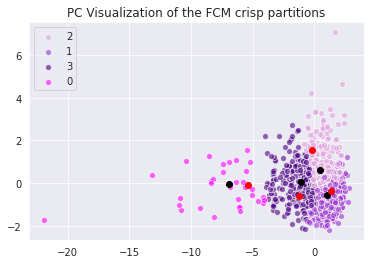

In [ ]:
count=np.zeros((4,1))
for i in range(len(df)):
  if(k[i]==0):
    col="magenta"
  if(k[i]==1):
    col="darkorchid"
  if(k[i]==2):
    col="plum"
  if(k[i]==3):
    col="indigo"
  count[k[i]]+=1
  if (count[k[i]]<=1):
   plt.scatter(ddf["1st_PC"][i],ddf["2nd_PC"][i], color=col,alpha=0.6,edgecolors="white",label=k[i])
  else:
   plt.scatter(ddf["1st_PC"][i],ddf["2nd_PC"][i], color=col,alpha=0.6,edgecolors="white") 
plt.plot(c0[0],c0[1],'ko')
plt.plot(c1[0],c1[1],'ko')
plt.plot(c2[0],c2[1],'ko')
plt.plot(c3[0],c3[1],'ko')
plt.plot(x0[0],x0[1],'ro')
plt.plot(x1[0],x1[1],'ro')
plt.plot(x2[0],x2[1],'ro')
plt.plot(x3[0],x3[1],'ro')
plt.legend()
plt.title('PC Visualization of the FCM crisp partitions')

In [ ]:
#FUZZY partition plot preprocessing
clust=[]

for i in range(len(u)):
  if(k[i]==0):
   clust.append(i)
for i in range(len(u)):
  if(k[i]==1):
   clust.append(i)

for i in range(len(u)):
  if(k[i]==2):
   clust.append(i)

for i in range(len(u)):
  if(k[i]==3):
   clust.append(i)
u=u[clust,]

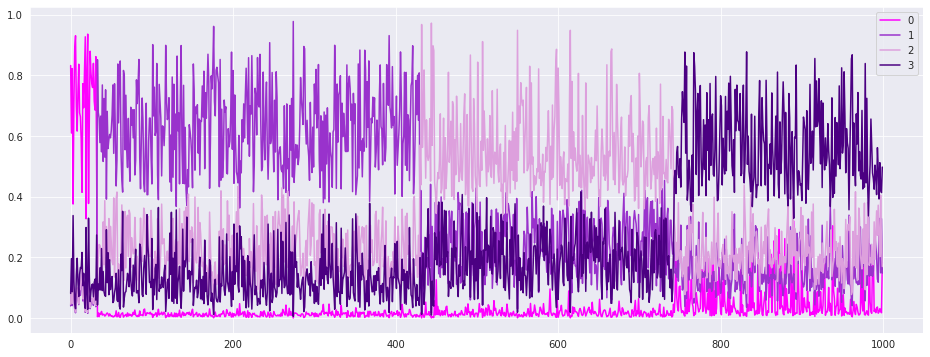

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(u[:,0],c="magenta")
plt.plot(u[:,1],c="darkorchid")
plt.plot(u[:,2],c="plum")
plt.plot(u[:,3],c="indigo")
plt.legend("0123")